# 6章　2値分類

In [1]:
# PDF印刷用
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

try:
    from google.colab import files
except:
    pass

pdf_ind = 2
pdf_base = 'pdf-06-'

def create_pdf(plt):
    global pdf_ind, pdf_base
    fn = f'{pdf_base}{pdf_ind:02d}.pdf'
    print(fn)
    plt.savefig(fn)
    try:
        files.download(fn)
    except:
        pass
    pdf_ind = pdf_ind + 1

In [2]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1

In [3]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [4]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot

In [5]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

## 6.3 シグモイド関数

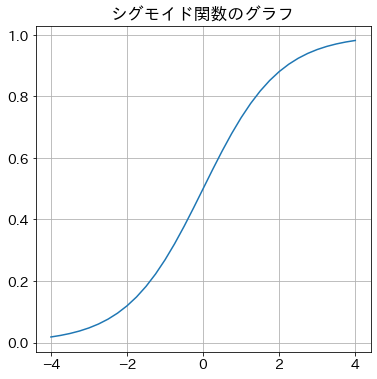

In [6]:
# NumPy配列でxデータを定義
x_np = np.arange(-4, 4.1, 0.25)

# データをTensor形式に変換
x = torch.tensor(x_np).float()

# yの値を計算
y = torch.sigmoid(x)

# グラフ描画
plt.title('シグモイド関数のグラフ')
plt.plot(x.data, y.data)
plt.show()

## 6.7 データ準備

In [7]:
# 学習用データ準備

# ライブラリのインポート
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


In [8]:
# データ絞り込み
#   クラス0, 1のみ
#   項目sepal_lengthとsepal_widthのみ

x_data = iris.data[:100,:2]
y_data = iris.target[:100]

# 結果確認
print('対象データ', x_data.shape, y_data.shape)

対象データ (100, 2) (100,)


### 学習データ・検証データの分割

In [9]:
# 　元データのサイズ
print(x_data.shape, y_data.shape)

# 学習データ、検証データに分割 (シャフルも同時に実施)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=70, test_size=30, 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 2) (100,)
(70, 2) (30, 2) (70,) (30,)


### 学習データの散布図表示

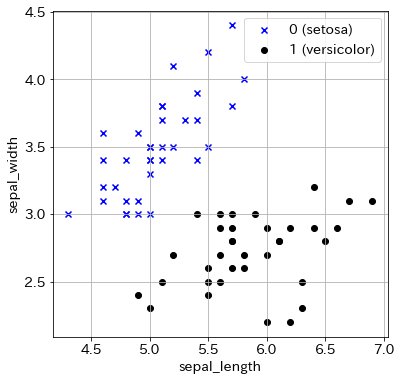

In [10]:
# 散布図の表示

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='k', label='1 (versicolor)')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()

## 6.8 モデル定義

In [11]:
# 入力次元数　(今の場合2)
n_input= x_train.shape[1]

# 出力次元数
n_output = 1

# 結果確認
print(f'n_input: {n_input}  n_output:{n_output}')

n_input: 2  n_output:1


In [12]:
# モデルの定義
# 2入力1出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.sigmoid = nn.Sigmoid()
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)        
        
    # 予測関数の定義
    def forward(self, x):
        # 最初に入力値と行列の積を計算する
        x1 = self.l1(x)
        # 計算結果にシグモイド関数をかける
        x2 = self.sigmoid(x1)
        return x2

In [13]:
# インスタンスの生成

net = Net(n_input, n_output)

### モデル確認

In [14]:
# モデル内のパラメータの確認
# l1.weightとl1.biasがあることがわかる

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1.], requires_grad=True))


In [15]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [16]:
# モデルのサマリー表示

summary(net, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
           Sigmoid-2                    [-1, 1]               0
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### 最適化アルゴリズムと損失関数

In [17]:
# 学習率
lr = 0.01

# アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.BCELoss()

## 6.9 勾配降下法

In [18]:
# 入力変数x_trainと正解値 y_trainのテンソル化

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()

# 正解ラベルはN行1列の行列に変換する
labels1 = labels.view((-1,1))

# 検証用変数のTensor化
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()

# 正解ラベルはN行1列の行列に変換する
labels1_test = labels_test.view((-1,1))

In [19]:
g.render('pdf-05-xx', view=False)

NameError: name 'g' is not defined

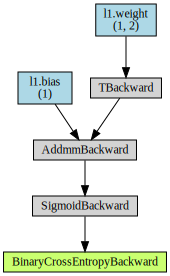

In [20]:
# 予測値の計算
outputs = net(inputs)

#  損失値の計算
loss = criterion(outputs, labels1)

# 損失関数のグラフ化
g = make_dot(loss, params=dict(net.named_parameters()))
g.render('pdf-05-xx', view=False)
display(g)

### 繰り返し計算

In [21]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： 交差エントロピー関数
criterion = nn.BCELoss()

# 繰り返し回数
num_epochs = 10000

# 記録用リストの初期化
history = np.zeros((0,5))

In [22]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    # 訓練フェーズ
    
    #勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 誤差計算
    loss = criterion(outputs, labels1)

    # 勾配計算
    loss.backward()
    
    # 重み修正
    optimizer.step()

    # 　訓練データの損失値
    train_loss = loss.item()

    # 予測ラベル(1 or 0)計算
    predicted = torch.where(outputs < 0.5, 0, 1)
    
    # 精度計算
    train_acc = (predicted == labels1).sum() / len(y_train)

    # 予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 誤差計算
    loss_test = criterion(outputs_test, labels1_test)

    # 損失値
    val_loss =  loss_test.item()
        
    #予測ラベル(1 or 0)計算
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)

    # 精度計算
    val_acc = (predicted_test == labels1_test).sum() / len(y_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 4.77289 acc: 0.50000 val_loss: 4.49384, val_acc: 0.50000
Epoch [10/10000], loss: 3.80546 acc: 0.50000 val_loss: 3.56537, val_acc: 0.50000
Epoch [20/10000], loss: 2.84328 acc: 0.50000 val_loss: 2.64328, val_acc: 0.50000
Epoch [30/10000], loss: 1.91613 acc: 0.50000 val_loss: 1.76244, val_acc: 0.50000
Epoch [40/10000], loss: 1.17137 acc: 0.50000 val_loss: 1.08537, val_acc: 0.50000
Epoch [50/10000], loss: 0.84140 acc: 0.50000 val_loss: 0.81872, val_acc: 0.50000
Epoch [60/10000], loss: 0.77087 acc: 0.50000 val_loss: 0.77093, val_acc: 0.50000
Epoch [70/10000], loss: 0.75450 acc: 0.34286 val_loss: 0.76105, val_acc: 0.33333
Epoch [80/10000], loss: 0.74542 acc: 0.25714 val_loss: 0.75447, val_acc: 0.20000
Epoch [90/10000], loss: 0.73734 acc: 0.24286 val_loss: 0.74778, val_acc: 0.16667
Epoch [100/10000], loss: 0.72949 acc: 0.24286 val_loss: 0.74098, val_acc: 0.13333
Epoch [110/10000], loss: 0.72180 acc: 0.27143 val_loss: 0.73419, val_acc: 0.16667
Epoch [120/10000], loss: 0.

Epoch [1100/10000], loss: 0.34266 acc: 1.00000 val_loss: 0.39004, val_acc: 0.96667
Epoch [1110/10000], loss: 0.34089 acc: 1.00000 val_loss: 0.38839, val_acc: 0.96667
Epoch [1120/10000], loss: 0.33913 acc: 1.00000 val_loss: 0.38677, val_acc: 0.96667
Epoch [1130/10000], loss: 0.33739 acc: 1.00000 val_loss: 0.38516, val_acc: 0.96667
Epoch [1140/10000], loss: 0.33568 acc: 1.00000 val_loss: 0.38356, val_acc: 0.96667
Epoch [1150/10000], loss: 0.33398 acc: 1.00000 val_loss: 0.38199, val_acc: 0.96667
Epoch [1160/10000], loss: 0.33230 acc: 1.00000 val_loss: 0.38043, val_acc: 0.96667
Epoch [1170/10000], loss: 0.33064 acc: 1.00000 val_loss: 0.37889, val_acc: 0.96667
Epoch [1180/10000], loss: 0.32900 acc: 1.00000 val_loss: 0.37737, val_acc: 0.96667
Epoch [1190/10000], loss: 0.32737 acc: 1.00000 val_loss: 0.37586, val_acc: 0.96667
Epoch [1200/10000], loss: 0.32577 acc: 1.00000 val_loss: 0.37437, val_acc: 0.96667
Epoch [1210/10000], loss: 0.32418 acc: 1.00000 val_loss: 0.37290, val_acc: 0.96667
Epoc

Epoch [2280/10000], loss: 0.21718 acc: 1.00000 val_loss: 0.27384, val_acc: 0.96667
Epoch [2290/10000], loss: 0.21655 acc: 1.00000 val_loss: 0.27326, val_acc: 0.96667
Epoch [2300/10000], loss: 0.21592 acc: 1.00000 val_loss: 0.27269, val_acc: 0.96667
Epoch [2310/10000], loss: 0.21530 acc: 1.00000 val_loss: 0.27211, val_acc: 0.96667
Epoch [2320/10000], loss: 0.21468 acc: 1.00000 val_loss: 0.27155, val_acc: 0.96667
Epoch [2330/10000], loss: 0.21407 acc: 1.00000 val_loss: 0.27098, val_acc: 0.96667
Epoch [2340/10000], loss: 0.21346 acc: 1.00000 val_loss: 0.27042, val_acc: 0.96667
Epoch [2350/10000], loss: 0.21285 acc: 1.00000 val_loss: 0.26987, val_acc: 0.96667
Epoch [2360/10000], loss: 0.21225 acc: 1.00000 val_loss: 0.26932, val_acc: 0.96667
Epoch [2370/10000], loss: 0.21165 acc: 1.00000 val_loss: 0.26877, val_acc: 0.96667
Epoch [2380/10000], loss: 0.21106 acc: 1.00000 val_loss: 0.26822, val_acc: 0.96667
Epoch [2390/10000], loss: 0.21047 acc: 1.00000 val_loss: 0.26768, val_acc: 0.96667
Epoc

Epoch [3460/10000], loss: 0.16389 acc: 1.00000 val_loss: 0.22538, val_acc: 0.96667
Epoch [3470/10000], loss: 0.16357 acc: 1.00000 val_loss: 0.22509, val_acc: 0.96667
Epoch [3480/10000], loss: 0.16325 acc: 1.00000 val_loss: 0.22480, val_acc: 0.96667
Epoch [3490/10000], loss: 0.16293 acc: 1.00000 val_loss: 0.22452, val_acc: 0.96667
Epoch [3500/10000], loss: 0.16261 acc: 1.00000 val_loss: 0.22423, val_acc: 0.96667
Epoch [3510/10000], loss: 0.16229 acc: 1.00000 val_loss: 0.22395, val_acc: 0.96667
Epoch [3520/10000], loss: 0.16198 acc: 1.00000 val_loss: 0.22367, val_acc: 0.96667
Epoch [3530/10000], loss: 0.16166 acc: 1.00000 val_loss: 0.22339, val_acc: 0.96667
Epoch [3540/10000], loss: 0.16135 acc: 1.00000 val_loss: 0.22311, val_acc: 0.96667
Epoch [3550/10000], loss: 0.16104 acc: 1.00000 val_loss: 0.22283, val_acc: 0.96667
Epoch [3560/10000], loss: 0.16073 acc: 1.00000 val_loss: 0.22255, val_acc: 0.96667
Epoch [3570/10000], loss: 0.16043 acc: 1.00000 val_loss: 0.22228, val_acc: 0.96667
Epoc

Epoch [4640/10000], loss: 0.13407 acc: 1.00000 val_loss: 0.19898, val_acc: 0.96667
Epoch [4650/10000], loss: 0.13387 acc: 1.00000 val_loss: 0.19881, val_acc: 0.96667
Epoch [4660/10000], loss: 0.13367 acc: 1.00000 val_loss: 0.19864, val_acc: 0.96667
Epoch [4670/10000], loss: 0.13348 acc: 1.00000 val_loss: 0.19847, val_acc: 0.96667
Epoch [4680/10000], loss: 0.13328 acc: 1.00000 val_loss: 0.19830, val_acc: 0.96667
Epoch [4690/10000], loss: 0.13308 acc: 1.00000 val_loss: 0.19813, val_acc: 0.96667
Epoch [4700/10000], loss: 0.13289 acc: 1.00000 val_loss: 0.19796, val_acc: 0.96667
Epoch [4710/10000], loss: 0.13270 acc: 1.00000 val_loss: 0.19779, val_acc: 0.96667
Epoch [4720/10000], loss: 0.13250 acc: 1.00000 val_loss: 0.19762, val_acc: 0.96667
Epoch [4730/10000], loss: 0.13231 acc: 1.00000 val_loss: 0.19746, val_acc: 0.96667
Epoch [4740/10000], loss: 0.13212 acc: 1.00000 val_loss: 0.19729, val_acc: 0.96667
Epoch [4750/10000], loss: 0.13193 acc: 1.00000 val_loss: 0.19712, val_acc: 0.96667
Epoc

Epoch [5810/10000], loss: 0.11493 acc: 1.00000 val_loss: 0.18253, val_acc: 0.96667
Epoch [5820/10000], loss: 0.11480 acc: 1.00000 val_loss: 0.18242, val_acc: 0.96667
Epoch [5830/10000], loss: 0.11466 acc: 1.00000 val_loss: 0.18231, val_acc: 0.96667
Epoch [5840/10000], loss: 0.11453 acc: 1.00000 val_loss: 0.18219, val_acc: 0.96667
Epoch [5850/10000], loss: 0.11439 acc: 1.00000 val_loss: 0.18208, val_acc: 0.96667
Epoch [5860/10000], loss: 0.11426 acc: 1.00000 val_loss: 0.18197, val_acc: 0.96667
Epoch [5870/10000], loss: 0.11413 acc: 1.00000 val_loss: 0.18185, val_acc: 0.96667
Epoch [5880/10000], loss: 0.11399 acc: 1.00000 val_loss: 0.18174, val_acc: 0.96667
Epoch [5890/10000], loss: 0.11386 acc: 1.00000 val_loss: 0.18163, val_acc: 0.96667
Epoch [5900/10000], loss: 0.11373 acc: 1.00000 val_loss: 0.18152, val_acc: 0.96667
Epoch [5910/10000], loss: 0.11360 acc: 1.00000 val_loss: 0.18141, val_acc: 0.96667
Epoch [5920/10000], loss: 0.11347 acc: 1.00000 val_loss: 0.18130, val_acc: 0.96667
Epoc

Epoch [6990/10000], loss: 0.10130 acc: 1.00000 val_loss: 0.17117, val_acc: 0.96667
Epoch [7000/10000], loss: 0.10121 acc: 1.00000 val_loss: 0.17109, val_acc: 0.96667
Epoch [7010/10000], loss: 0.10111 acc: 1.00000 val_loss: 0.17101, val_acc: 0.96667
Epoch [7020/10000], loss: 0.10101 acc: 1.00000 val_loss: 0.17093, val_acc: 0.96667
Epoch [7030/10000], loss: 0.10091 acc: 1.00000 val_loss: 0.17085, val_acc: 0.96667
Epoch [7040/10000], loss: 0.10081 acc: 1.00000 val_loss: 0.17077, val_acc: 0.96667
Epoch [7050/10000], loss: 0.10072 acc: 1.00000 val_loss: 0.17069, val_acc: 0.96667
Epoch [7060/10000], loss: 0.10062 acc: 1.00000 val_loss: 0.17061, val_acc: 0.96667
Epoch [7070/10000], loss: 0.10052 acc: 1.00000 val_loss: 0.17053, val_acc: 0.96667
Epoch [7080/10000], loss: 0.10043 acc: 1.00000 val_loss: 0.17045, val_acc: 0.96667
Epoch [7090/10000], loss: 0.10033 acc: 1.00000 val_loss: 0.17037, val_acc: 0.96667
Epoch [7100/10000], loss: 0.10023 acc: 1.00000 val_loss: 0.17029, val_acc: 0.96667
Epoc

Epoch [8160/10000], loss: 0.09120 acc: 1.00000 val_loss: 0.16300, val_acc: 0.96667
Epoch [8170/10000], loss: 0.09112 acc: 1.00000 val_loss: 0.16294, val_acc: 0.96667
Epoch [8180/10000], loss: 0.09105 acc: 1.00000 val_loss: 0.16288, val_acc: 0.96667
Epoch [8190/10000], loss: 0.09097 acc: 1.00000 val_loss: 0.16282, val_acc: 0.96667
Epoch [8200/10000], loss: 0.09089 acc: 1.00000 val_loss: 0.16276, val_acc: 0.96667
Epoch [8210/10000], loss: 0.09082 acc: 1.00000 val_loss: 0.16270, val_acc: 0.96667
Epoch [8220/10000], loss: 0.09074 acc: 1.00000 val_loss: 0.16264, val_acc: 0.96667
Epoch [8230/10000], loss: 0.09067 acc: 1.00000 val_loss: 0.16258, val_acc: 0.96667
Epoch [8240/10000], loss: 0.09060 acc: 1.00000 val_loss: 0.16252, val_acc: 0.96667
Epoch [8250/10000], loss: 0.09052 acc: 1.00000 val_loss: 0.16246, val_acc: 0.96667
Epoch [8260/10000], loss: 0.09045 acc: 1.00000 val_loss: 0.16240, val_acc: 0.96667
Epoch [8270/10000], loss: 0.09037 acc: 1.00000 val_loss: 0.16234, val_acc: 0.96667
Epoc

Epoch [9340/10000], loss: 0.08324 acc: 1.00000 val_loss: 0.15676, val_acc: 0.96667
Epoch [9350/10000], loss: 0.08318 acc: 1.00000 val_loss: 0.15672, val_acc: 0.96667
Epoch [9360/10000], loss: 0.08312 acc: 1.00000 val_loss: 0.15667, val_acc: 0.96667
Epoch [9370/10000], loss: 0.08306 acc: 1.00000 val_loss: 0.15662, val_acc: 0.96667
Epoch [9380/10000], loss: 0.08300 acc: 1.00000 val_loss: 0.15658, val_acc: 0.96667
Epoch [9390/10000], loss: 0.08294 acc: 1.00000 val_loss: 0.15653, val_acc: 0.96667
Epoch [9400/10000], loss: 0.08288 acc: 1.00000 val_loss: 0.15649, val_acc: 0.96667
Epoch [9410/10000], loss: 0.08282 acc: 1.00000 val_loss: 0.15644, val_acc: 0.96667
Epoch [9420/10000], loss: 0.08276 acc: 1.00000 val_loss: 0.15640, val_acc: 0.96667
Epoch [9430/10000], loss: 0.08270 acc: 1.00000 val_loss: 0.15635, val_acc: 0.96667
Epoch [9440/10000], loss: 0.08265 acc: 1.00000 val_loss: 0.15630, val_acc: 0.96667
Epoch [9450/10000], loss: 0.08259 acc: 1.00000 val_loss: 0.15626, val_acc: 0.96667
Epoc

## 6.10 結果確認

In [23]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 4.49384 精度: 0.50000
最終状態: 損失関数: 0.15395 精度: 0.96667


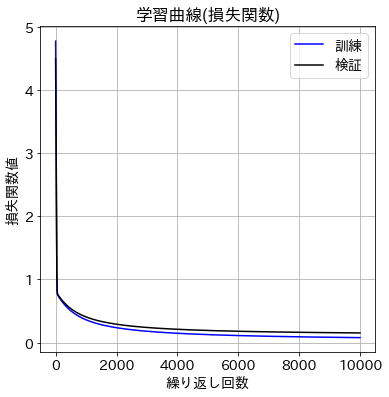

In [24]:
# 学習曲線の表示 (損失関数)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

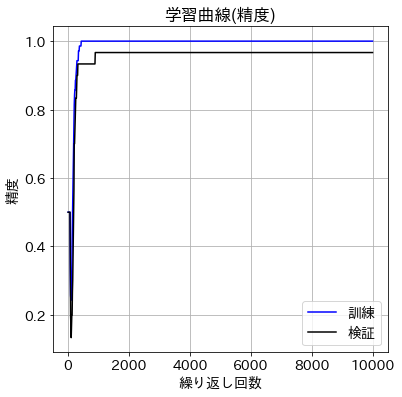

In [25]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

### 決定境界のグラフ表示

In [26]:
# 検証データを散布図用に準備

x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

In [27]:
# 重みの取得

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 決定境界描画用 x1の値から x2の値を計算する
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 散布図のx1の最小値と最大値
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 結果確認
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.3386128], WEIGHT = [[ 2.9700322 -5.300015 ]]
xl = [4.4 7. ]  yl = [2.52956918 3.986562  ]


pdf-06-02.pdf


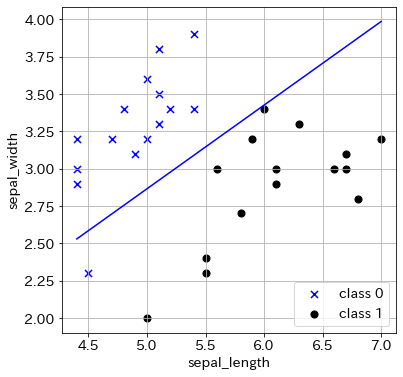

In [28]:
# 散布図表示
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', 
        c='k', s=50, label='class 1')

# 決定境界直線
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()

## コラム　BCELoss関数とBCEWithLogitsLoss関数の違い

In [27]:
# モデルの定義
# 2入力1出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)        
        
    # 予測関数の定義
    def forward(self, x):
        # 入力値と行列の積を計算する
        x1 = self.l1(x)
        return x1

In [28]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： logits付き交差エントロピー関数
criterion = nn.BCEWithLogitsLoss()

# 繰り返し回数
num_epochs = 10000

# 記録用リストの初期化
history = np.zeros((0,5))

In [29]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    # 訓練フェーズ
    
    #勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 誤差計算
    loss = criterion(outputs, labels1)

    # 勾配計算
    loss.backward()
    
    # 重み修正
    optimizer.step()

    # 　訓練データの損失値
    train_loss = loss.item()

    # 予測ラベル(1 or 0)計算
    predicted = torch.where(outputs < 0.0, 0, 1)
    
    # 精度計算
    train_acc = (predicted == labels1).sum() / len(y_train)

    # 予測フェーズ
    with torch.no_grad():

        # 予測計算
        outputs_test = net(inputs_test)

        # 誤差計算
        loss_test = criterion(outputs_test, labels1_test)

        # 損失値
        val_loss =  loss_test.item()
        
        #予測ラベル(1 or 0)計算
        predicted_test = torch.where(outputs_test < 0.0, 0, 1)

        # 精度計算
        val_acc = (predicted_test == labels1_test).sum() / len(y_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 4.77294 acc: 0.50000 val_loss: 4.49384, val_acc: 0.50000
Epoch [10/10000], loss: 3.80546 acc: 0.50000 val_loss: 3.56537, val_acc: 0.50000
Epoch [20/10000], loss: 2.84328 acc: 0.50000 val_loss: 2.64328, val_acc: 0.50000
Epoch [30/10000], loss: 1.91613 acc: 0.50000 val_loss: 1.76244, val_acc: 0.50000
Epoch [40/10000], loss: 1.17137 acc: 0.50000 val_loss: 1.08537, val_acc: 0.50000
Epoch [50/10000], loss: 0.84140 acc: 0.50000 val_loss: 0.81872, val_acc: 0.50000
Epoch [60/10000], loss: 0.77087 acc: 0.50000 val_loss: 0.77093, val_acc: 0.50000
Epoch [70/10000], loss: 0.75450 acc: 0.34286 val_loss: 0.76105, val_acc: 0.33333
Epoch [80/10000], loss: 0.74542 acc: 0.25714 val_loss: 0.75447, val_acc: 0.20000
Epoch [90/10000], loss: 0.73734 acc: 0.24286 val_loss: 0.74778, val_acc: 0.16667
Epoch [100/10000], loss: 0.72949 acc: 0.24286 val_loss: 0.74098, val_acc: 0.13333
Epoch [110/10000], loss: 0.72180 acc: 0.27143 val_loss: 0.73419, val_acc: 0.16667
Epoch [120/10000], loss: 0.

Epoch [1090/10000], loss: 0.34446 acc: 1.00000 val_loss: 0.39171, val_acc: 0.96667
Epoch [1100/10000], loss: 0.34266 acc: 1.00000 val_loss: 0.39004, val_acc: 0.96667
Epoch [1110/10000], loss: 0.34089 acc: 1.00000 val_loss: 0.38839, val_acc: 0.96667
Epoch [1120/10000], loss: 0.33913 acc: 1.00000 val_loss: 0.38677, val_acc: 0.96667
Epoch [1130/10000], loss: 0.33739 acc: 1.00000 val_loss: 0.38516, val_acc: 0.96667
Epoch [1140/10000], loss: 0.33568 acc: 1.00000 val_loss: 0.38357, val_acc: 0.96667
Epoch [1150/10000], loss: 0.33398 acc: 1.00000 val_loss: 0.38199, val_acc: 0.96667
Epoch [1160/10000], loss: 0.33230 acc: 1.00000 val_loss: 0.38043, val_acc: 0.96667
Epoch [1170/10000], loss: 0.33064 acc: 1.00000 val_loss: 0.37889, val_acc: 0.96667
Epoch [1180/10000], loss: 0.32900 acc: 1.00000 val_loss: 0.37737, val_acc: 0.96667
Epoch [1190/10000], loss: 0.32737 acc: 1.00000 val_loss: 0.37586, val_acc: 0.96667
Epoch [1200/10000], loss: 0.32577 acc: 1.00000 val_loss: 0.37437, val_acc: 0.96667
Epoc

Epoch [2110/10000], loss: 0.22859 acc: 1.00000 val_loss: 0.28435, val_acc: 0.96667
Epoch [2120/10000], loss: 0.22788 acc: 1.00000 val_loss: 0.28369, val_acc: 0.96667
Epoch [2130/10000], loss: 0.22718 acc: 1.00000 val_loss: 0.28304, val_acc: 0.96667
Epoch [2140/10000], loss: 0.22648 acc: 1.00000 val_loss: 0.28240, val_acc: 0.96667
Epoch [2150/10000], loss: 0.22578 acc: 1.00000 val_loss: 0.28176, val_acc: 0.96667
Epoch [2160/10000], loss: 0.22509 acc: 1.00000 val_loss: 0.28112, val_acc: 0.96667
Epoch [2170/10000], loss: 0.22441 acc: 1.00000 val_loss: 0.28049, val_acc: 0.96667
Epoch [2180/10000], loss: 0.22373 acc: 1.00000 val_loss: 0.27986, val_acc: 0.96667
Epoch [2190/10000], loss: 0.22305 acc: 1.00000 val_loss: 0.27924, val_acc: 0.96667
Epoch [2200/10000], loss: 0.22238 acc: 1.00000 val_loss: 0.27862, val_acc: 0.96667
Epoch [2210/10000], loss: 0.22171 acc: 1.00000 val_loss: 0.27801, val_acc: 0.96667
Epoch [2220/10000], loss: 0.22105 acc: 1.00000 val_loss: 0.27740, val_acc: 0.96667
Epoc

Epoch [3100/10000], loss: 0.17662 acc: 1.00000 val_loss: 0.23685, val_acc: 0.96667
Epoch [3110/10000], loss: 0.17624 acc: 1.00000 val_loss: 0.23650, val_acc: 0.96667
Epoch [3120/10000], loss: 0.17585 acc: 1.00000 val_loss: 0.23615, val_acc: 0.96667
Epoch [3130/10000], loss: 0.17547 acc: 1.00000 val_loss: 0.23580, val_acc: 0.96667
Epoch [3140/10000], loss: 0.17509 acc: 1.00000 val_loss: 0.23546, val_acc: 0.96667
Epoch [3150/10000], loss: 0.17471 acc: 1.00000 val_loss: 0.23512, val_acc: 0.96667
Epoch [3160/10000], loss: 0.17434 acc: 1.00000 val_loss: 0.23478, val_acc: 0.96667
Epoch [3170/10000], loss: 0.17396 acc: 1.00000 val_loss: 0.23444, val_acc: 0.96667
Epoch [3180/10000], loss: 0.17359 acc: 1.00000 val_loss: 0.23411, val_acc: 0.96667
Epoch [3190/10000], loss: 0.17322 acc: 1.00000 val_loss: 0.23377, val_acc: 0.96667
Epoch [3200/10000], loss: 0.17285 acc: 1.00000 val_loss: 0.23344, val_acc: 0.96667
Epoch [3210/10000], loss: 0.17249 acc: 1.00000 val_loss: 0.23311, val_acc: 0.96667
Epoc

Epoch [4250/10000], loss: 0.14238 acc: 1.00000 val_loss: 0.20626, val_acc: 0.96667
Epoch [4260/10000], loss: 0.14215 acc: 1.00000 val_loss: 0.20606, val_acc: 0.96667
Epoch [4270/10000], loss: 0.14192 acc: 1.00000 val_loss: 0.20586, val_acc: 0.96667
Epoch [4280/10000], loss: 0.14170 acc: 1.00000 val_loss: 0.20566, val_acc: 0.96667
Epoch [4290/10000], loss: 0.14147 acc: 1.00000 val_loss: 0.20546, val_acc: 0.96667
Epoch [4300/10000], loss: 0.14124 acc: 1.00000 val_loss: 0.20526, val_acc: 0.96667
Epoch [4310/10000], loss: 0.14102 acc: 1.00000 val_loss: 0.20507, val_acc: 0.96667
Epoch [4320/10000], loss: 0.14080 acc: 1.00000 val_loss: 0.20487, val_acc: 0.96667
Epoch [4330/10000], loss: 0.14057 acc: 1.00000 val_loss: 0.20467, val_acc: 0.96667
Epoch [4340/10000], loss: 0.14035 acc: 1.00000 val_loss: 0.20448, val_acc: 0.96667
Epoch [4350/10000], loss: 0.14013 acc: 1.00000 val_loss: 0.20429, val_acc: 0.96667
Epoch [4360/10000], loss: 0.13991 acc: 1.00000 val_loss: 0.20409, val_acc: 0.96667
Epoc

Epoch [5390/10000], loss: 0.12099 acc: 1.00000 val_loss: 0.18768, val_acc: 0.96667
Epoch [5400/10000], loss: 0.12083 acc: 1.00000 val_loss: 0.18755, val_acc: 0.96667
Epoch [5410/10000], loss: 0.12068 acc: 1.00000 val_loss: 0.18742, val_acc: 0.96667
Epoch [5420/10000], loss: 0.12053 acc: 1.00000 val_loss: 0.18729, val_acc: 0.96667
Epoch [5430/10000], loss: 0.12037 acc: 1.00000 val_loss: 0.18716, val_acc: 0.96667
Epoch [5440/10000], loss: 0.12022 acc: 1.00000 val_loss: 0.18703, val_acc: 0.96667
Epoch [5450/10000], loss: 0.12007 acc: 1.00000 val_loss: 0.18690, val_acc: 0.96667
Epoch [5460/10000], loss: 0.11992 acc: 1.00000 val_loss: 0.18678, val_acc: 0.96667
Epoch [5470/10000], loss: 0.11977 acc: 1.00000 val_loss: 0.18665, val_acc: 0.96667
Epoch [5480/10000], loss: 0.11962 acc: 1.00000 val_loss: 0.18652, val_acc: 0.96667
Epoch [5490/10000], loss: 0.11947 acc: 1.00000 val_loss: 0.18639, val_acc: 0.96667
Epoch [5500/10000], loss: 0.11932 acc: 1.00000 val_loss: 0.18627, val_acc: 0.96667
Epoc

Epoch [6440/10000], loss: 0.10712 acc: 1.00000 val_loss: 0.17598, val_acc: 0.96667
Epoch [6450/10000], loss: 0.10701 acc: 1.00000 val_loss: 0.17589, val_acc: 0.96667
Epoch [6460/10000], loss: 0.10690 acc: 1.00000 val_loss: 0.17579, val_acc: 0.96667
Epoch [6470/10000], loss: 0.10679 acc: 1.00000 val_loss: 0.17570, val_acc: 0.96667
Epoch [6480/10000], loss: 0.10667 acc: 1.00000 val_loss: 0.17560, val_acc: 0.96667
Epoch [6490/10000], loss: 0.10656 acc: 1.00000 val_loss: 0.17551, val_acc: 0.96667
Epoch [6500/10000], loss: 0.10645 acc: 1.00000 val_loss: 0.17542, val_acc: 0.96667
Epoch [6510/10000], loss: 0.10634 acc: 1.00000 val_loss: 0.17533, val_acc: 0.96667
Epoch [6520/10000], loss: 0.10623 acc: 1.00000 val_loss: 0.17523, val_acc: 0.96667
Epoch [6530/10000], loss: 0.10612 acc: 1.00000 val_loss: 0.17514, val_acc: 0.96667
Epoch [6540/10000], loss: 0.10600 acc: 1.00000 val_loss: 0.17505, val_acc: 0.96667
Epoch [6550/10000], loss: 0.10589 acc: 1.00000 val_loss: 0.17496, val_acc: 0.96667
Epoc

Epoch [7550/10000], loss: 0.09613 acc: 1.00000 val_loss: 0.16696, val_acc: 0.96667
Epoch [7560/10000], loss: 0.09605 acc: 1.00000 val_loss: 0.16689, val_acc: 0.96667
Epoch [7570/10000], loss: 0.09596 acc: 1.00000 val_loss: 0.16682, val_acc: 0.96667
Epoch [7580/10000], loss: 0.09587 acc: 1.00000 val_loss: 0.16675, val_acc: 0.96667
Epoch [7590/10000], loss: 0.09579 acc: 1.00000 val_loss: 0.16668, val_acc: 0.96667
Epoch [7600/10000], loss: 0.09570 acc: 1.00000 val_loss: 0.16661, val_acc: 0.96667
Epoch [7610/10000], loss: 0.09562 acc: 1.00000 val_loss: 0.16654, val_acc: 0.96667
Epoch [7620/10000], loss: 0.09553 acc: 1.00000 val_loss: 0.16647, val_acc: 0.96667
Epoch [7630/10000], loss: 0.09545 acc: 1.00000 val_loss: 0.16640, val_acc: 0.96667
Epoch [7640/10000], loss: 0.09536 acc: 1.00000 val_loss: 0.16633, val_acc: 0.96667
Epoch [7650/10000], loss: 0.09528 acc: 1.00000 val_loss: 0.16626, val_acc: 0.96667
Epoch [7660/10000], loss: 0.09519 acc: 1.00000 val_loss: 0.16620, val_acc: 0.96667
Epoc

Epoch [8690/10000], loss: 0.08739 acc: 1.00000 val_loss: 0.15999, val_acc: 0.96667
Epoch [8700/10000], loss: 0.08733 acc: 1.00000 val_loss: 0.15994, val_acc: 0.96667
Epoch [8710/10000], loss: 0.08726 acc: 1.00000 val_loss: 0.15989, val_acc: 0.96667
Epoch [8720/10000], loss: 0.08719 acc: 1.00000 val_loss: 0.15983, val_acc: 0.96667
Epoch [8730/10000], loss: 0.08712 acc: 1.00000 val_loss: 0.15978, val_acc: 0.96667
Epoch [8740/10000], loss: 0.08706 acc: 1.00000 val_loss: 0.15973, val_acc: 0.96667
Epoch [8750/10000], loss: 0.08699 acc: 1.00000 val_loss: 0.15967, val_acc: 0.96667
Epoch [8760/10000], loss: 0.08692 acc: 1.00000 val_loss: 0.15962, val_acc: 0.96667
Epoch [8770/10000], loss: 0.08685 acc: 1.00000 val_loss: 0.15957, val_acc: 0.96667
Epoch [8780/10000], loss: 0.08679 acc: 1.00000 val_loss: 0.15952, val_acc: 0.96667
Epoch [8790/10000], loss: 0.08672 acc: 1.00000 val_loss: 0.15946, val_acc: 0.96667
Epoch [8800/10000], loss: 0.08665 acc: 1.00000 val_loss: 0.15941, val_acc: 0.96667
Epoc

Epoch [9790/10000], loss: 0.08064 acc: 1.00000 val_loss: 0.15477, val_acc: 0.96667
Epoch [9800/10000], loss: 0.08059 acc: 1.00000 val_loss: 0.15473, val_acc: 0.96667
Epoch [9810/10000], loss: 0.08053 acc: 1.00000 val_loss: 0.15469, val_acc: 0.96667
Epoch [9820/10000], loss: 0.08048 acc: 1.00000 val_loss: 0.15465, val_acc: 0.96667
Epoch [9830/10000], loss: 0.08042 acc: 1.00000 val_loss: 0.15461, val_acc: 0.96667
Epoch [9840/10000], loss: 0.08037 acc: 1.00000 val_loss: 0.15456, val_acc: 0.96667
Epoch [9850/10000], loss: 0.08031 acc: 1.00000 val_loss: 0.15452, val_acc: 0.96667
Epoch [9860/10000], loss: 0.08026 acc: 1.00000 val_loss: 0.15448, val_acc: 0.96667
Epoch [9870/10000], loss: 0.08020 acc: 1.00000 val_loss: 0.15444, val_acc: 0.96667
Epoch [9880/10000], loss: 0.08015 acc: 1.00000 val_loss: 0.15440, val_acc: 0.96667
Epoch [9890/10000], loss: 0.08009 acc: 1.00000 val_loss: 0.15436, val_acc: 0.96667
Epoch [9900/10000], loss: 0.08004 acc: 1.00000 val_loss: 0.15432, val_acc: 0.96667
Epoc

In [30]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 4.49384 精度: 0.50000
最終状態: 損失関数: 0.15395 精度: 0.96667


pdf-06-04.pdf


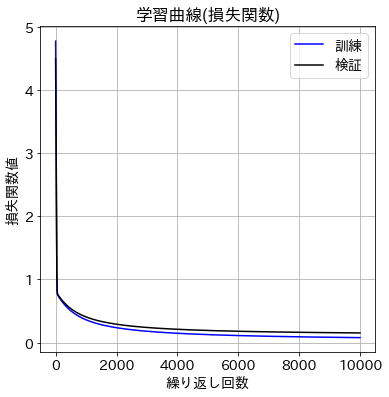

In [31]:
# 学習曲線の表示 (損失関数)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

pdf-06-05.pdf


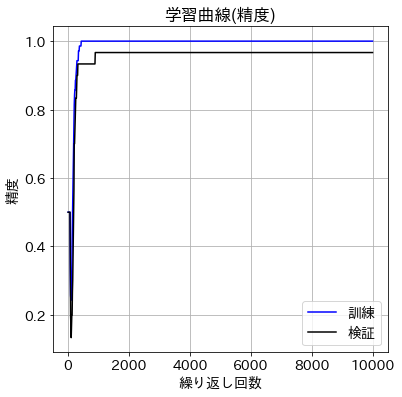

In [32]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

In [34]:
# 重みの取得

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 決定境界描画用 x1の値から x2の値を計算する
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 散布図のx1の最小値と最大値
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 結果確認
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.3386128], WEIGHT = [[ 2.9700322 -5.300015 ]]
xl = [4.4 7. ]  yl = [2.52956918 3.986562  ]


pdf-06-06.pdf


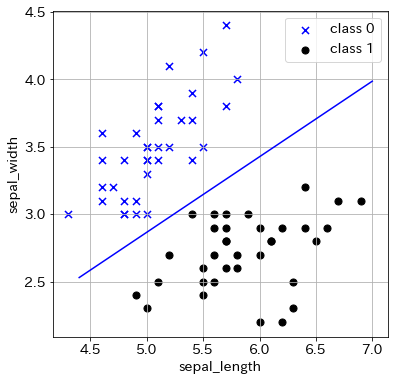

In [35]:
# 散布図表示
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', 
        c='k', s=50, label='class 1')

# 決定境界直線
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()

## コラム　BCELoss関数とBCEWithLogitsLoss関数の違い

In [36]:
# モデルの定義
# 2入力1出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
                
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的        
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)        
        
    # 予測関数の定義
    def forward(self, x):
        # 入力値と行列の積を計算する
        x1 = self.l1(x)
        return x1

In [37]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 損失関数： logits付き交差エントロピー関数
criterion = nn.BCEWithLogitsLoss()

# 繰り返し回数
num_epochs = 10000

# 記録用リストの初期化
history = np.zeros((0,5))

In [38]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    # 訓練フェーズ
    
    #勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 誤差計算
    loss = criterion(outputs, labels1)

    # 勾配計算
    loss.backward()
    
    # 重み修正
    optimizer.step()

    # 　訓練データの損失値
    train_loss = loss.item()

    # 予測ラベル(1 or 0)計算
    predicted = torch.where(outputs < 0.0, 0, 1)
    
    # 精度計算
    train_acc = (predicted == labels1).sum() / len(y_train)

    # 予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 誤差計算
    loss_test = criterion(outputs_test, labels1_test)

    # 損失値
    val_loss =  loss_test.item()
        
    #予測ラベル(1 or 0)計算
    predicted_test = torch.where(outputs_test < 0.0, 0, 1)

    # 精度計算
    val_acc = (predicted_test == labels1_test).sum() / len(y_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 4.77294 acc: 0.50000 val_loss: 4.49384, val_acc: 0.50000
Epoch [10/10000], loss: 3.80546 acc: 0.50000 val_loss: 3.56537, val_acc: 0.50000
Epoch [20/10000], loss: 2.84328 acc: 0.50000 val_loss: 2.64328, val_acc: 0.50000
Epoch [30/10000], loss: 1.91613 acc: 0.50000 val_loss: 1.76244, val_acc: 0.50000
Epoch [40/10000], loss: 1.17137 acc: 0.50000 val_loss: 1.08537, val_acc: 0.50000
Epoch [50/10000], loss: 0.84140 acc: 0.50000 val_loss: 0.81872, val_acc: 0.50000
Epoch [60/10000], loss: 0.77087 acc: 0.50000 val_loss: 0.77093, val_acc: 0.50000
Epoch [70/10000], loss: 0.75450 acc: 0.34286 val_loss: 0.76105, val_acc: 0.33333
Epoch [80/10000], loss: 0.74542 acc: 0.25714 val_loss: 0.75447, val_acc: 0.20000
Epoch [90/10000], loss: 0.73734 acc: 0.24286 val_loss: 0.74778, val_acc: 0.16667
Epoch [100/10000], loss: 0.72949 acc: 0.24286 val_loss: 0.74098, val_acc: 0.13333
Epoch [110/10000], loss: 0.72180 acc: 0.27143 val_loss: 0.73419, val_acc: 0.16667
Epoch [120/10000], loss: 0.

Epoch [1110/10000], loss: 0.34089 acc: 1.00000 val_loss: 0.38839, val_acc: 0.96667
Epoch [1120/10000], loss: 0.33913 acc: 1.00000 val_loss: 0.38677, val_acc: 0.96667
Epoch [1130/10000], loss: 0.33739 acc: 1.00000 val_loss: 0.38516, val_acc: 0.96667
Epoch [1140/10000], loss: 0.33568 acc: 1.00000 val_loss: 0.38356, val_acc: 0.96667
Epoch [1150/10000], loss: 0.33398 acc: 1.00000 val_loss: 0.38199, val_acc: 0.96667
Epoch [1160/10000], loss: 0.33230 acc: 1.00000 val_loss: 0.38043, val_acc: 0.96667
Epoch [1170/10000], loss: 0.33064 acc: 1.00000 val_loss: 0.37889, val_acc: 0.96667
Epoch [1180/10000], loss: 0.32900 acc: 1.00000 val_loss: 0.37737, val_acc: 0.96667
Epoch [1190/10000], loss: 0.32737 acc: 1.00000 val_loss: 0.37586, val_acc: 0.96667
Epoch [1200/10000], loss: 0.32577 acc: 1.00000 val_loss: 0.37437, val_acc: 0.96667
Epoch [1210/10000], loss: 0.32418 acc: 1.00000 val_loss: 0.37290, val_acc: 0.96667
Epoch [1220/10000], loss: 0.32260 acc: 1.00000 val_loss: 0.37144, val_acc: 0.96667
Epoc

Epoch [2290/10000], loss: 0.21655 acc: 1.00000 val_loss: 0.27326, val_acc: 0.96667
Epoch [2300/10000], loss: 0.21592 acc: 1.00000 val_loss: 0.27269, val_acc: 0.96667
Epoch [2310/10000], loss: 0.21530 acc: 1.00000 val_loss: 0.27211, val_acc: 0.96667
Epoch [2320/10000], loss: 0.21468 acc: 1.00000 val_loss: 0.27155, val_acc: 0.96667
Epoch [2330/10000], loss: 0.21407 acc: 1.00000 val_loss: 0.27098, val_acc: 0.96667
Epoch [2340/10000], loss: 0.21346 acc: 1.00000 val_loss: 0.27042, val_acc: 0.96667
Epoch [2350/10000], loss: 0.21285 acc: 1.00000 val_loss: 0.26987, val_acc: 0.96667
Epoch [2360/10000], loss: 0.21225 acc: 1.00000 val_loss: 0.26932, val_acc: 0.96667
Epoch [2370/10000], loss: 0.21165 acc: 1.00000 val_loss: 0.26877, val_acc: 0.96667
Epoch [2380/10000], loss: 0.21106 acc: 1.00000 val_loss: 0.26822, val_acc: 0.96667
Epoch [2390/10000], loss: 0.21047 acc: 1.00000 val_loss: 0.26768, val_acc: 0.96667
Epoch [2400/10000], loss: 0.20988 acc: 1.00000 val_loss: 0.26715, val_acc: 0.96667
Epoc

Epoch [3490/10000], loss: 0.16293 acc: 1.00000 val_loss: 0.22452, val_acc: 0.96667
Epoch [3500/10000], loss: 0.16261 acc: 1.00000 val_loss: 0.22423, val_acc: 0.96667
Epoch [3510/10000], loss: 0.16229 acc: 1.00000 val_loss: 0.22395, val_acc: 0.96667
Epoch [3520/10000], loss: 0.16198 acc: 1.00000 val_loss: 0.22367, val_acc: 0.96667
Epoch [3530/10000], loss: 0.16166 acc: 1.00000 val_loss: 0.22339, val_acc: 0.96667
Epoch [3540/10000], loss: 0.16135 acc: 1.00000 val_loss: 0.22311, val_acc: 0.96667
Epoch [3550/10000], loss: 0.16104 acc: 1.00000 val_loss: 0.22283, val_acc: 0.96667
Epoch [3560/10000], loss: 0.16073 acc: 1.00000 val_loss: 0.22255, val_acc: 0.96667
Epoch [3570/10000], loss: 0.16043 acc: 1.00000 val_loss: 0.22228, val_acc: 0.96667
Epoch [3580/10000], loss: 0.16012 acc: 1.00000 val_loss: 0.22200, val_acc: 0.96667
Epoch [3590/10000], loss: 0.15981 acc: 1.00000 val_loss: 0.22173, val_acc: 0.96667
Epoch [3600/10000], loss: 0.15951 acc: 1.00000 val_loss: 0.22146, val_acc: 0.96667
Epoc

Epoch [4690/10000], loss: 0.13308 acc: 1.00000 val_loss: 0.19813, val_acc: 0.96667
Epoch [4700/10000], loss: 0.13289 acc: 1.00000 val_loss: 0.19796, val_acc: 0.96667
Epoch [4710/10000], loss: 0.13270 acc: 1.00000 val_loss: 0.19779, val_acc: 0.96667
Epoch [4720/10000], loss: 0.13250 acc: 1.00000 val_loss: 0.19762, val_acc: 0.96667
Epoch [4730/10000], loss: 0.13231 acc: 1.00000 val_loss: 0.19746, val_acc: 0.96667
Epoch [4740/10000], loss: 0.13212 acc: 1.00000 val_loss: 0.19729, val_acc: 0.96667
Epoch [4750/10000], loss: 0.13193 acc: 1.00000 val_loss: 0.19712, val_acc: 0.96667
Epoch [4760/10000], loss: 0.13174 acc: 1.00000 val_loss: 0.19696, val_acc: 0.96667
Epoch [4770/10000], loss: 0.13155 acc: 1.00000 val_loss: 0.19679, val_acc: 0.96667
Epoch [4780/10000], loss: 0.13136 acc: 1.00000 val_loss: 0.19663, val_acc: 0.96667
Epoch [4790/10000], loss: 0.13117 acc: 1.00000 val_loss: 0.19647, val_acc: 0.96667
Epoch [4800/10000], loss: 0.13099 acc: 1.00000 val_loss: 0.19630, val_acc: 0.96667
Epoc

Epoch [5870/10000], loss: 0.11413 acc: 1.00000 val_loss: 0.18185, val_acc: 0.96667
Epoch [5880/10000], loss: 0.11399 acc: 1.00000 val_loss: 0.18174, val_acc: 0.96667
Epoch [5890/10000], loss: 0.11386 acc: 1.00000 val_loss: 0.18163, val_acc: 0.96667
Epoch [5900/10000], loss: 0.11373 acc: 1.00000 val_loss: 0.18152, val_acc: 0.96667
Epoch [5910/10000], loss: 0.11360 acc: 1.00000 val_loss: 0.18141, val_acc: 0.96667
Epoch [5920/10000], loss: 0.11347 acc: 1.00000 val_loss: 0.18130, val_acc: 0.96667
Epoch [5930/10000], loss: 0.11333 acc: 1.00000 val_loss: 0.18119, val_acc: 0.96667
Epoch [5940/10000], loss: 0.11320 acc: 1.00000 val_loss: 0.18108, val_acc: 0.96667
Epoch [5950/10000], loss: 0.11307 acc: 1.00000 val_loss: 0.18097, val_acc: 0.96667
Epoch [5960/10000], loss: 0.11294 acc: 1.00000 val_loss: 0.18086, val_acc: 0.96667
Epoch [5970/10000], loss: 0.11282 acc: 1.00000 val_loss: 0.18075, val_acc: 0.96667
Epoch [5980/10000], loss: 0.11269 acc: 1.00000 val_loss: 0.18064, val_acc: 0.96667
Epoc

Epoch [7030/10000], loss: 0.10091 acc: 1.00000 val_loss: 0.17085, val_acc: 0.96667
Epoch [7040/10000], loss: 0.10081 acc: 1.00000 val_loss: 0.17077, val_acc: 0.96667
Epoch [7050/10000], loss: 0.10072 acc: 1.00000 val_loss: 0.17069, val_acc: 0.96667
Epoch [7060/10000], loss: 0.10062 acc: 1.00000 val_loss: 0.17061, val_acc: 0.96667
Epoch [7070/10000], loss: 0.10052 acc: 1.00000 val_loss: 0.17053, val_acc: 0.96667
Epoch [7080/10000], loss: 0.10043 acc: 1.00000 val_loss: 0.17045, val_acc: 0.96667
Epoch [7090/10000], loss: 0.10033 acc: 1.00000 val_loss: 0.17037, val_acc: 0.96667
Epoch [7100/10000], loss: 0.10023 acc: 1.00000 val_loss: 0.17029, val_acc: 0.96667
Epoch [7110/10000], loss: 0.10014 acc: 1.00000 val_loss: 0.17021, val_acc: 0.96667
Epoch [7120/10000], loss: 0.10004 acc: 1.00000 val_loss: 0.17014, val_acc: 0.96667
Epoch [7130/10000], loss: 0.09995 acc: 1.00000 val_loss: 0.17006, val_acc: 0.96667
Epoch [7140/10000], loss: 0.09985 acc: 1.00000 val_loss: 0.16998, val_acc: 0.96667
Epoc

Epoch [8220/10000], loss: 0.09074 acc: 1.00000 val_loss: 0.16264, val_acc: 0.96667
Epoch [8230/10000], loss: 0.09067 acc: 1.00000 val_loss: 0.16258, val_acc: 0.96667
Epoch [8240/10000], loss: 0.09060 acc: 1.00000 val_loss: 0.16252, val_acc: 0.96667
Epoch [8250/10000], loss: 0.09052 acc: 1.00000 val_loss: 0.16246, val_acc: 0.96667
Epoch [8260/10000], loss: 0.09045 acc: 1.00000 val_loss: 0.16240, val_acc: 0.96667
Epoch [8270/10000], loss: 0.09037 acc: 1.00000 val_loss: 0.16234, val_acc: 0.96667
Epoch [8280/10000], loss: 0.09030 acc: 1.00000 val_loss: 0.16228, val_acc: 0.96667
Epoch [8290/10000], loss: 0.09023 acc: 1.00000 val_loss: 0.16222, val_acc: 0.96667
Epoch [8300/10000], loss: 0.09015 acc: 1.00000 val_loss: 0.16217, val_acc: 0.96667
Epoch [8310/10000], loss: 0.09008 acc: 1.00000 val_loss: 0.16211, val_acc: 0.96667
Epoch [8320/10000], loss: 0.09000 acc: 1.00000 val_loss: 0.16205, val_acc: 0.96667
Epoch [8330/10000], loss: 0.08993 acc: 1.00000 val_loss: 0.16199, val_acc: 0.96667
Epoc

Epoch [9410/10000], loss: 0.08282 acc: 1.00000 val_loss: 0.15644, val_acc: 0.96667
Epoch [9420/10000], loss: 0.08276 acc: 1.00000 val_loss: 0.15640, val_acc: 0.96667
Epoch [9430/10000], loss: 0.08270 acc: 1.00000 val_loss: 0.15635, val_acc: 0.96667
Epoch [9440/10000], loss: 0.08265 acc: 1.00000 val_loss: 0.15630, val_acc: 0.96667
Epoch [9450/10000], loss: 0.08259 acc: 1.00000 val_loss: 0.15626, val_acc: 0.96667
Epoch [9460/10000], loss: 0.08253 acc: 1.00000 val_loss: 0.15621, val_acc: 0.96667
Epoch [9470/10000], loss: 0.08247 acc: 1.00000 val_loss: 0.15617, val_acc: 0.96667
Epoch [9480/10000], loss: 0.08241 acc: 1.00000 val_loss: 0.15612, val_acc: 0.96667
Epoch [9490/10000], loss: 0.08235 acc: 1.00000 val_loss: 0.15608, val_acc: 0.96667
Epoch [9500/10000], loss: 0.08229 acc: 1.00000 val_loss: 0.15603, val_acc: 0.96667
Epoch [9510/10000], loss: 0.08224 acc: 1.00000 val_loss: 0.15599, val_acc: 0.96667
Epoch [9520/10000], loss: 0.08218 acc: 1.00000 val_loss: 0.15594, val_acc: 0.96667
Epoc

In [39]:
#損失関数値と精度の確認

print(f'初期状態: 損失関数: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失関数: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失関数: 4.49384 精度: 0.50000
最終状態: 損失関数: 0.15395 精度: 0.96667


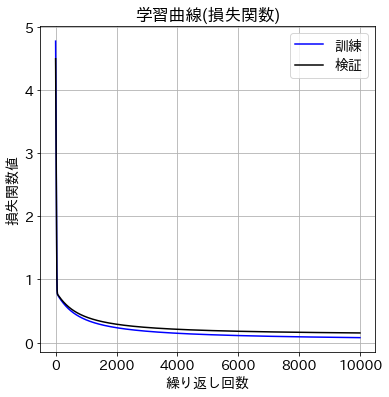

In [40]:
# 学習曲線の表示 (損失関数)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失関数値')
plt.title('学習曲線(損失関数)')
plt.legend()
plt.show()

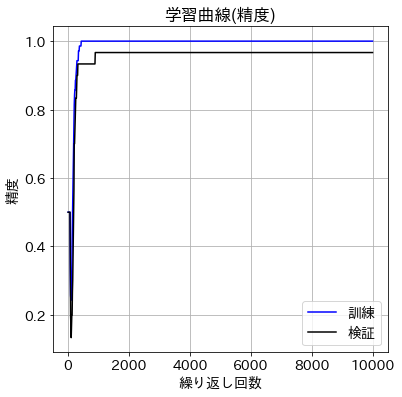

In [41]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

In [42]:
# 重みの取得

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 決定境界描画用 x1の値から x2の値を計算する
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 散布図のx1の最小値と最大値
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 結果確認
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.3386128], WEIGHT = [[ 2.9700322 -5.300015 ]]
xl = [4.4 7. ]  yl = [2.52956918 3.986562  ]


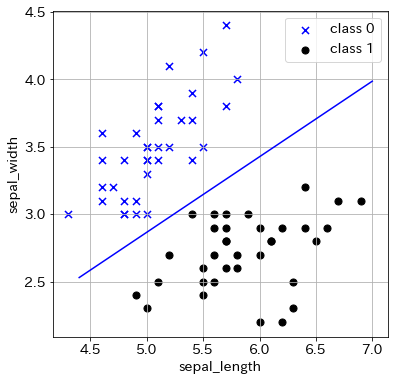

In [43]:
# 散布図表示
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', 
        c='k', s=50, label='class 1')

# 決定境界直線
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()